In [1]:
# Essentials 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Preprocessing
from preprocess import preprocessor
from preprocess import clean_df
from preprocess import define_vocab_to_remove
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from collections import Counter

# Machine learning
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

# **Sequence model**
In this notebook we will implement a sequence model for our classification problem using pytorch. <br>
First we import the data and preprocess it.

In [2]:
data = pd.read_csv("labelled_newscatcher_dataset.csv", sep=";")

In [3]:
# We sample the data to 10% of the dataset to have feasable training time for testing
sampled_data = data.sample(frac=0.1, random_state=42)
X,y = clean_df(sampled_data)


# Then we preprocess the data using the preprocessor function from preprocess.py
words_to_remove = define_vocab_to_remove(X,1,10000)

for i in range(len(X)):
    X.iloc[i] = preprocessor(X.iloc[i], words_to_remove)

To train a sequence model with an embedding layer we will need to define a vocabulary first. To do so we will use **word_tokenizer** from nltk 

In [4]:
df = pd.DataFrame({"title":X, "topic": y})

def tokenize(text):
    return word_tokenize(text)

def numerize_pad(df):
    all_text = ' '.join(df['title'])
    tokens = tokenize(all_text)
    vocab = Counter(tokens)


    word_to_idx = {word: idx + 1 for idx, (word, _) in enumerate(vocab.most_common())}
    word_to_idx['<PAD>'] = 0  # Padding token


    df['text_indices'] = df['title'].apply(lambda x: [word_to_idx[token] for token in tokenize(x)])
    return (df,word_to_idx)

df, word_to_idx = numerize_pad(df)

Let's set our training data, and target

In [5]:
X = df.text_indices
y = df.topic

Let's check the overall distribution of our sample

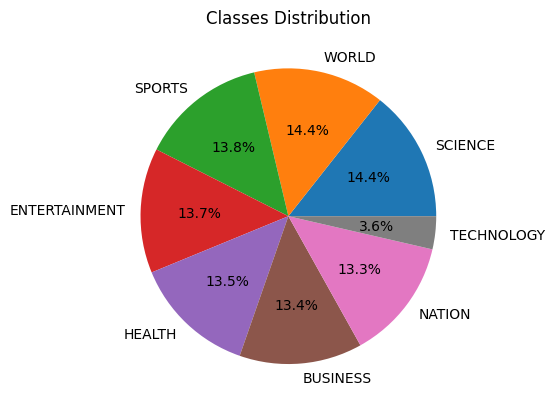

In [6]:
plt.pie(y.value_counts(), labels = y.unique().tolist(), autopct='%1.1f%%')
plt.title("Classes Distribution")
plt.show()


We see that the technology class is the least represented. We will need to keep this in mind when evaluating the model

## **Preparation of train and test data set**

We first encode our target column with a **label_encoder**

In [7]:
class_labels = ['BUSINESS', 'ENTERTAINMENT', 'HEALTH', 'NATION', 'SCIENCE', 'SPORTS', 'TECHNOLOGY', 'WORLD']

label_encoder = LabelEncoder() # instantiate a label encoder 
y_enc = label_encoder.fit_transform(y)

We then convert X and y to torch tensors, split them into training and test samples, and finally instanciates dataloaders for the training of the model

In [8]:
# This function converts to tensor and applies padding to the whole dataset. It then splits the data to training and test set
def set_train_test(X,y_enc):
    X_tensor = [torch.tensor(seq, dtype=torch.long) for seq in X]
    y_tensor = torch.tensor(y_enc, dtype=torch.long)

    # We want to apply padding, so that the input data has always the same sequence length. Without it the model will not work 
    X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=0) 

    # We then split the data into training and testing samples
    X_train,X_test,y_train,y_test = train_test_split(X_padded,y_tensor,test_size=0.2)

    return (X_train,X_test,y_train,y_test)

# This function instanciates data loaders for training and test dataset.
def set_loaders(X_train, X_test, y_train, y_test):
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 64 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return(train_loader,test_loader)


Let's use these functions to prepare the data

In [9]:
X_train, X_test, y_train, y_test  = set_train_test(X,y_enc)
train_loader, test_loader = set_loaders(X_train, X_test, y_train, y_test)

## **Defining the model**


Then we need to define a sequence model. For this problem I decided to use a Long Short-Term Memory (LSTM) networks. It allows to capture information over long sequence which seems useful in this case as the training data can be very heavy. Additionnaly, the processing can be set to bidirection, which can handle forward and backward pass well.

Here is the model's overall architecture:
- **Embedding layer :** This layer convert the indices into vectors of size `embedding_dim`

- **LSTM layer :** This layer, as mentioned above, process input in forward and backward direction to capture the meaning of the sentences. The output shape is defined by `hidden_dim`

- **Max pooling :** This operation allows to get the maximum value of the LSTM layer, and reducing it to a fix dimension

- **Fully Connected layer :** This layer linearly transform the input into a lower dimension set to the number of classes (8) as it is the final output 

- **Dropout layer :** This layer sets a fraction defined by `dropout` back to zero to prevent some overfitting after each iterations


<br>
The input of this model are sequences of indices that represents words from the vocabulary of the data, and the final output is a prediction for each class

In [10]:
class TitleClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, nb_classes, dropout ):
        super(TitleClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2,nb_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self,X):
        X = self.embedding(X)
        output,_ = self.lstm(X)
        max_pooled, _ = torch.max(output, dim=1)
        output = self.fc(max_pooled)
        output = self.dropout(output)
  
        return output

We can now call the TitleClassifier class and train the model. We will need to define some parameters
* **vocab_size** : Defines the initial input shape 
* **embedding_dim :** Defines the output dimension of the embedding layer
* **hidden_dim :** Defines the output dimension of the LTSM layer
* **nb_classes :** Defines the final output dimension (8 in our case)
* **nb_epochs :** Defines the number of iterations the model will train for
* **learning_rate :** Defines the learning rate the model will apply at every step

In [11]:
# Arbitrary parameter for now
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_dim = 64
nb_classes = 8
nb_epochs = 50
learning_rate = 0.001
dropout = 0.5

# This function trains the model based on the parameter and return the trained model and a list containing the averaged traingin loss over each epoch
# I decide to create this function to quickly adapt parameter and sample size.

def train_model(learning_rate, nb_epochs, embedding_dim, hidden_dim, dropout, train_loader):
    Model = TitleClassifier(vocab_size, embedding_dim, hidden_dim, nb_classes,dropout)

    criterion = nn.CrossEntropyLoss()  # Loss function to compute 
    optimizer = optim.Adam(Model.parameters(), lr=learning_rate) # The optimizing parameter for the model

    loss_epoch = [] # We want to keep track of the training loss for every epoch
    for epoch in range(nb_epochs):
        loss_list = []
        i=0
        for i,(text,y) in enumerate(train_loader):  
            optimizer.zero_grad()
            output = Model(text)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().numpy().astype(float)) 
            print(f"Epoch : {epoch+1} and batch n° : {i+1}     loss = {loss}") 
        loss_epoch.append(np.mean(loss_list))
    return (Model,loss_epoch)

In [12]:
Model, loss_epoch = train_model(learning_rate, nb_epochs, embedding_dim, hidden_dim, dropout, train_loader)

Epoch : 1 and batch n° : 1     loss = 2.1268301010131836
Epoch : 1 and batch n° : 2     loss = 2.0709214210510254
Epoch : 1 and batch n° : 3     loss = 2.069897174835205
Epoch : 1 and batch n° : 4     loss = 2.045862913131714
Epoch : 1 and batch n° : 5     loss = 2.107064723968506
Epoch : 1 and batch n° : 6     loss = 2.086773633956909
Epoch : 1 and batch n° : 7     loss = 2.020272731781006
Epoch : 1 and batch n° : 8     loss = 2.0915331840515137
Epoch : 1 and batch n° : 9     loss = 2.0468130111694336
Epoch : 1 and batch n° : 10     loss = 2.064028024673462
Epoch : 1 and batch n° : 11     loss = 2.064714193344116
Epoch : 1 and batch n° : 12     loss = 2.0818288326263428
Epoch : 1 and batch n° : 13     loss = 2.078528642654419
Epoch : 1 and batch n° : 14     loss = 2.0402488708496094
Epoch : 1 and batch n° : 15     loss = 2.054481029510498
Epoch : 1 and batch n° : 16     loss = 2.0710761547088623
Epoch : 1 and batch n° : 17     loss = 2.0691347122192383
Epoch : 1 and batch n° : 18     

We want to plot the loss over the number of epochs the model has train for

In [13]:
# This function display the training loss over the epochs
def plot_training_loss(loss_epoch):
    plt.plot(range(1,len(loss_epoch)+1), loss_epoch)
    plt.title("Training loss over number of epochs")
    plt.xlabel("Number of epoch")
    plt.ylabel("Training loss")
    plt.grid(True)
    plt.show()

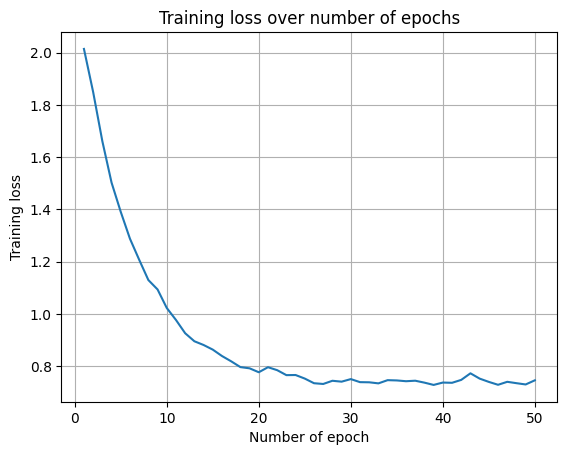

In [14]:
plot_training_loss(loss_epoch)

We can see that the loss is steadily decreasing until epoch 20. Here it seems that for the parameters I applied, the model seems to stabilize at around 30 to 40 epochs.
For the sample I used it probably a good thing to reduce the amount of epoch to prevent any sort of overfitting

## **Hyperparameter Tuning**
we want to see here is we can optimize the learning_rate and the number of epochs the model is training on

In [15]:
learning_rate = [0.01, 0.001, 0.0001]
nb_epochs = [10, 20, 30]

Model_list = []
for lr in learning_rate:
    for epoch in nb_epochs:
        Model, loss_epoch = train_model(lr, epoch, embedding_dim, hidden_dim, dropout, train_loader)
        Model_list.append((Model,loss_epoch,[lr,epoch]))

Epoch : 1 and batch n° : 1     loss = 2.083765745162964
Epoch : 1 and batch n° : 2     loss = 2.197570562362671
Epoch : 1 and batch n° : 3     loss = 2.0554819107055664
Epoch : 1 and batch n° : 4     loss = 2.0537924766540527
Epoch : 1 and batch n° : 5     loss = 2.05833101272583
Epoch : 1 and batch n° : 6     loss = 1.9907877445220947
Epoch : 1 and batch n° : 7     loss = 2.073284864425659
Epoch : 1 and batch n° : 8     loss = 2.1662495136260986
Epoch : 1 and batch n° : 9     loss = 2.0991640090942383
Epoch : 1 and batch n° : 10     loss = 2.0112364292144775
Epoch : 1 and batch n° : 11     loss = 2.027951955795288
Epoch : 1 and batch n° : 12     loss = 2.0012075901031494
Epoch : 1 and batch n° : 13     loss = 2.0019447803497314
Epoch : 1 and batch n° : 14     loss = 2.05100679397583
Epoch : 1 and batch n° : 15     loss = 2.030735492706299
Epoch : 1 and batch n° : 16     loss = 2.064480781555176
Epoch : 1 and batch n° : 17     loss = 2.079749584197998
Epoch : 1 and batch n° : 18     lo

## **Evaluating the model**
We now want to evaluate the model, on our testing data. To do that I dfined a function that uses the test_loader created previosulty to test a model, and compute an accuracy score. 

In [16]:
def eval_model(Model, test_loader):
    Model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for test,y  in test_loader:
            test_outputs = Model(test)
            _, predicted = torch.max(test_outputs, 1)
            correct_predictions += (predicted == y).sum().item() # For every batch, it adds the number of correct preduictions 


    accuracy = correct_predictions / len(y_test) # we then divide the total by the size of the testing data
    return accuracy

I then called the function on all the model training to see which one perform best and with which of the parameter

In [17]:
for Model in Model_list:
    accuracy = eval_model(Model[0],test_loader)
    print(f"The accuracy of the model for the following parameter : learning rate {Model[2][0]} and epoch {Model[2][1]} is {accuracy}")

The accuracy of the model for the following parameter : learning rate 0.01 and epoch 10 is 0.6672794117647058
The accuracy of the model for the following parameter : learning rate 0.01 and epoch 20 is 0.6672794117647058
The accuracy of the model for the following parameter : learning rate 0.01 and epoch 30 is 0.6631433823529411
The accuracy of the model for the following parameter : learning rate 0.001 and epoch 10 is 0.6282169117647058
The accuracy of the model for the following parameter : learning rate 0.001 and epoch 20 is 0.6392463235294118
The accuracy of the model for the following parameter : learning rate 0.001 and epoch 30 is 0.6300551470588235
The accuracy of the model for the following parameter : learning rate 0.0001 and epoch 10 is 0.4053308823529412
The accuracy of the model for the following parameter : learning rate 0.0001 and epoch 20 is 0.49264705882352944
The accuracy of the model for the following parameter : learning rate 0.0001 and epoch 30 is 0.5404411764705882


The best model here is with the following parameters learning_rate 0.01 and epoch set to 20

Let's plot the training loss of the best model to see how it performed over time

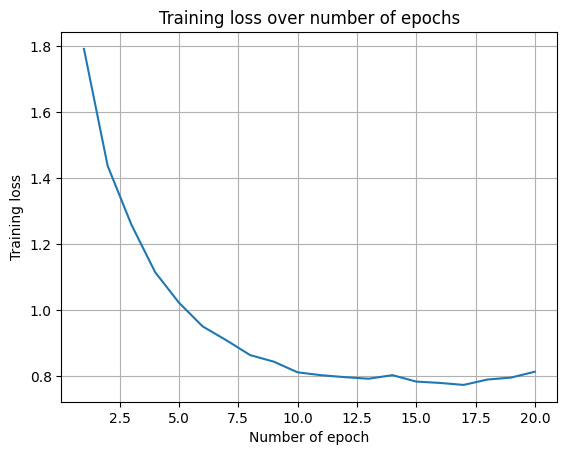

In [18]:
plot_training_loss(Model_list[1][1])

We can see from the training loss that the model has stabilized between 10 and 20 epochs. It doesn't seem to be overfitting too much with these parameter

## **Testing the model on larger a dataset**
I tested the model for a small fraction of the overall data. Let's now see how it perform on the whole dataset. The LSTM layer is supposed to handle large sequence over long training. As the vocabulary size will be much larger, I expect some improvement compared to the previous models.

Lets compute all the previous step without sampling the data. This is were the different functions comes into play.

In [20]:
X,y = clean_df(data)


# Then we preprocess the data using the preprocessor function from preprocess.py
words_to_remove = define_vocab_to_remove(X,1,10000)

for i in range(len(X)):
    X.iloc[i] = preprocessor(X.iloc[i], words_to_remove)

df = pd.DataFrame({"title":X, "topic": y})

df, word_to_idx = numerize_pad(df)

X = df.text_indices
y = df.topic

class_labels = ['BUSINESS', 'ENTERTAINMENT', 'HEALTH', 'NATION', 'SCIENCE', 'SPORTS', 'TECHNOLOGY', 'WORLD']

label_encoder = LabelEncoder() # instantiate a label encoder 
y_enc = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = set_train_test(X,y_enc)

train_loader, test_loader = set_loaders(X_train, X_test, y_train, y_test)

# I set the following parameters based on the previous test
vocab_size = len(word_to_idx)
embedding_dim = 100
hidden_dim = 64
nb_classes = 8
nb_epochs = 7 # I set it to only 7 to reduce the execution time, we will see if it impacts the training loss
learning_rate = 0.01
dropout = 0.5

Model, loss_epoch = train_model(learning_rate, nb_epochs, embedding_dim, hidden_dim, dropout, train_loader)

Epoch : 1 and batch n° : 1     loss = 2.1090247631073
Epoch : 1 and batch n° : 2     loss = 2.3062667846679688
Epoch : 1 and batch n° : 3     loss = 2.1124377250671387
Epoch : 1 and batch n° : 4     loss = 2.015824317932129
Epoch : 1 and batch n° : 5     loss = 2.09727144241333
Epoch : 1 and batch n° : 6     loss = 2.1116631031036377
Epoch : 1 and batch n° : 7     loss = 2.0257647037506104
Epoch : 1 and batch n° : 8     loss = 2.179696798324585
Epoch : 1 and batch n° : 9     loss = 2.0748164653778076
Epoch : 1 and batch n° : 10     loss = 2.077735662460327
Epoch : 1 and batch n° : 11     loss = 1.9923511743545532
Epoch : 1 and batch n° : 12     loss = 2.017690658569336
Epoch : 1 and batch n° : 13     loss = 1.9828517436981201
Epoch : 1 and batch n° : 14     loss = 2.007317304611206
Epoch : 1 and batch n° : 15     loss = 2.013237953186035
Epoch : 1 and batch n° : 16     loss = 2.083930015563965
Epoch : 1 and batch n° : 17     loss = 1.9498515129089355
Epoch : 1 and batch n° : 18     los

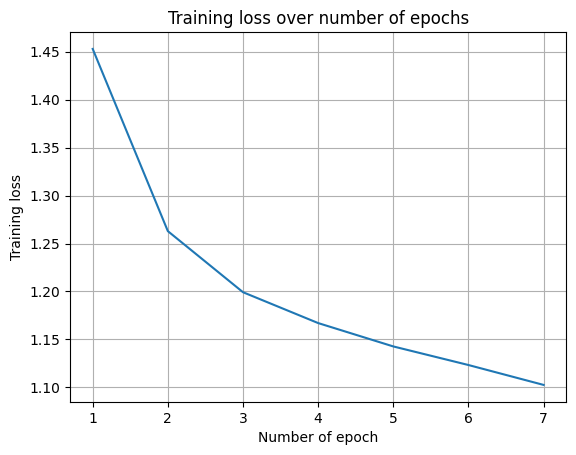

In [21]:
plot_training_loss(loss_epoch)

In [22]:
accuracy = eval_model(Model, test_loader)
accuracy

0.7742587910825097